In [7]:
import sys
import pdb
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import nclcmaps as ncm
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from cftime import DatetimeNoLeap as date
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 13,   # Axis labels
    'xtick.labelsize' : 11,   # X-axis tick labels
    'ytick.labelsize' : 11,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance

In [8]:
importlib.reload(putil)

def make_plot(latband, pres, ulev, ilev, budgetdates, sigvar='pval', ufreq='10daily'):

    # ----- whether or not to skip the non-source-tagged ensemble members
    skipnst=True
    
    # ----- get U data
    ub = putil.get_variable('U', skip_nosrctag=skipnst, freq=ufreq)
    # ----- get latband U data
    u = putil.get_variable('U', latmin=latband[0], latmax=latband[1], skip_nosrctag=skipnst, freq=ufreq)
    
    # ----- get dims
    time, plev = [u['cfmean'].time, u['cfmean'].plev]
    time       = [datetime(t.year,t.month,t.day) for t in time.values]
    lat        = ub['cfmean'].lat

    # ----- set limits
    plim      = [400, 0.3]
    timelim = [time[0], datetime(time[0].year+2,time[0].month,time[0].day)]

    # ---------- plot
    fig_width = 10
    fig = plt.figure(figsize=(fig_width, fig_width/3))
    ax = fig.add_subplot(111)
    
    # ----- get integrated tendencies
    fargs = {'latmin':latband[0], 'latmax':latband[1], 'skip_nosrctag':skipnst, 'freq':'daily'}
    pargs = {'plev':pres, 'method':'nearest'}
    
    # ----- get U
    uu = putil.get_variable('U', latmin=latband[0], latmax=latband[1], skip_nosrctag=skipnst, freq=ufreq)
    uu = uu['impact'].sel(**pargs) # U at the pressure level
    
    # ----- plotting settings
    pad               = 0.075  # padding space for inset axes
    ils, ilw, icolor  = ':', 1.33, 'k'    # line style, width, and color for zoom-in indicator rays 
    brlw, brcolor     = 3,'magenta' # line width and color for averaging region idicator on main figure
    blw, bslw         = 1.5, 6     # line with for integrated tendencies, significant integrated tendencies
    balpha            = 0.25     # alpha for significant integrated tendency highlight
    zls, zlw, zcolor  = ':', 1.2, 'grey' # zero-line linestyle, width, and color
    utls, utcolor     = '-','k'  # linestyle and color for integrated utend
    utepls, ueptcolor = '-','indianred'  # linestyle and color for integrated utendepfd
    utrvls, utrvcolor = '-','dodgerblue'  # linestyle and color for integrated utendresvel
    utvls, utvcolor   = '--','dodgerblue' # linestyle and color for integrated utendvtem
    utwls, utwcolor   = '-.','dodgerblue'  # linestyle and color for integrated utendwtem
    utdls, utdcolor   = '-','gold'  # linestyle and color for integrated utenddiff

    # ----- loop over all passed budgeting time windows
    nb = len(budgetdates)
    for i in range(nb):
        
        # get time coordinate and limits for zoom-in region
        bdates = budgetdates[i]
        blim   = putil.to_datetime(bdates)
        targs = {'tmin':bdates[0], 'tmax':bdates[1]}
        
        # pad and shift the axes so that they are evenly distributed across
        # the bottom of the figure. Took me forever to derive this.
        shrink = (nb-1)*pad/nb
        shift  = (np.arange(1, nb+1, 1)-1)*pad/nb
        
        # create axes for zoom-in region
        bax = ax2.inset_axes([i/nb + shift[i], -1.25, 1/nb - shrink, 1])
        # create zoom-in indicators from the main figure to the insets
        bax.set_ylim([pres-1e-6,pres+1e-6])
        bax.set_xlim(blim)
        zoomrect, zoomlines = ax2.indicate_inset_zoom(bax)
        for line in zoomlines:
            line.set_color(icolor)
            line.set_linewidth(ilw)
            line.set_linestyle(ils)
        ax2.plot(blim, [pres, pres], '-', color=brcolor, lw=brlw, zorder=300)
            
        # ----- get integrated tendencies initalized at this time
        ut   = putil.get_integrated_tendency('UTEND', tinit=bdates[0], **fargs)
        utep = putil.get_integrated_tendency('utendepfd', tinit=bdates[0], **fargs)
        utrv = putil.get_integrated_tendency('utendresvel', tinit=bdates[0], **fargs)
        utv  = putil.get_integrated_tendency('utendvtem', tinit=bdates[0], **fargs)
        utw  = putil.get_integrated_tendency('utendwtem', tinit=bdates[0], **fargs)
        utd  = putil.get_integrated_tendency('utenddiff', tinit=bdates[0], **fargs)
        # ----- slice
        ut   = putil.sel(putil.do_slicing(ut, **targs), **pargs)
        utep = putil.sel(putil.do_slicing(utep, **targs), **pargs)
        utrv = putil.sel(putil.do_slicing(utrv, **targs), **pargs)
        utv  = putil.sel(putil.do_slicing(utv, **targs), **pargs)
        utw  = putil.sel(putil.do_slicing(utw, **targs), **pargs)
        utd  = putil.sel(putil.do_slicing(utd, **targs), **pargs)
        # ----- get significance
        ut_sig = sig(ut['impact'], ut[sigvar], sigtype=sigvar)
        utep_sig = sig(utep['impact'], utep[sigvar], sigtype=sigvar)
        utrv_sig = sig(utrv['impact'], utrv[sigvar], sigtype=sigvar)
        utv_sig = sig(utv['impact'], utv[sigvar], sigtype=sigvar)
        utw_sig = sig(utw['impact'], utw[sigvar], sigtype=sigvar)
        utd_sig = sig(utd['impact'], utd[sigvar], sigtype=sigvar)

        # get time coordinate for plotting
        btime = putil.to_datetime(ut['impact'].time)
        
        # plot
        #bax.plot(btime, putil.do_slicing(uu, **targs), lw=blw*4, ls='--', color=utcolor) # plot U as sanity check on UTEND
        bax.plot(btime, ut['impact'], lw=blw, ls=utls, color=utcolor, label='$\partial\overline{u}/\partial{t}$')
        bax.plot(btime, utep['impact'], lw=blw, ls=utepls, color=ueptcolor, label='$\\nabla\cdot\mathbf{F}$')
        bax.plot(btime, utrv['impact'], lw=blw, ls=utrvls, color=utrvcolor, label='($v^*$, $w^*$)')
        bax.plot(btime, utv['impact'], lw=blw-0.3, ls=utvls, color=utvcolor, label='$v^*$')
        bax.plot(btime, utw['impact'], lw=blw-0.3, ls=utwls, color=utwcolor, label='$w^*$')
        bax.plot(btime, utd['impact'], lw=blw, ls=utdls, color=utdcolor, label='$\overline{X}$')
        
        # scale y-axis
        ydata = np.concatenate([line.get_ydata() for line in bax.get_lines()])
        ymin, ymax = np.min(ydata), np.max(ydata)
        bax.set_ylim([ymin-np.abs(ymin*0.1), ymax+np.abs(ymax*0.1)])
        
        # plot significance
        bax.plot(btime, ut_sig, lw=bslw, alpha=balpha, ls=utls, color=utcolor)
        bax.plot(btime, utep_sig, lw=bslw, alpha=balpha, ls=utepls, color=ueptcolor)
        bax.plot(btime, utrv_sig, lw=bslw, alpha=balpha, ls=utrvls, color=utrvcolor)
        bax.plot(btime, utv_sig, lw=bslw, alpha=balpha, ls=utrvls, color=utvcolor)
        bax.plot(btime, utw_sig, lw=bslw, alpha=balpha, ls=utrvls, color=utwcolor)
        bax.plot(btime, utd_sig, lw=bslw, alpha=balpha, ls=utdls, color=utdcolor)
        
        # zero line
        bax.axhline(y=0, lw=zlw, ls=zls, color=zcolor, zorder=0)
        
        # legend
        if(i==0):
            dummy = fig.add_axes(ax2.get_position(), frameon=False)
            dummy.tick_params(left=False, right=False, top=False, bottom=False,
                              labelleft=False, labelbottom=False)
            for line in bax.get_lines():
                dummy.plot([0],[0], lw=line.get_lw(), ls=line.get_ls(), color=line.get_color(), label=line.get_label())
            leg = dummy.legend(bbox_to_anchor=(0.5, -1.5), frameon=False, fancybox=False, edgecolor='k', ncol=6, columnspacing=1, handlelength=1.5, loc='center')
            leg.get_frame().set_linewidth(0.66)
        
        # formatting
        bax.set_xlim([btime[0], btime[-1]])
        putil.season_timeticks(bax, btime, 'month')
        bax.tick_params(top=True, bottom=True, left=True, right=True, 
                        labeltop=False, labelbottom=True, labelleft=True, labelright=False, 
                        which='both')
        if(i == 0):
            bax.set_ylabel('integrated \n$\overline{u}$ impact [m/s]')

<>:84: SyntaxWarning: invalid escape sequence '\o'
<>:122: SyntaxWarning: invalid escape sequence '\o'
<>:205: SyntaxWarning: invalid escape sequence '\p'
<>:206: SyntaxWarning: invalid escape sequence '\c'
<>:210: SyntaxWarning: invalid escape sequence '\o'
<>:245: SyntaxWarning: invalid escape sequence '\o'
<>:84: SyntaxWarning: invalid escape sequence '\o'
<>:122: SyntaxWarning: invalid escape sequence '\o'
<>:205: SyntaxWarning: invalid escape sequence '\p'
<>:206: SyntaxWarning: invalid escape sequence '\c'
<>:210: SyntaxWarning: invalid escape sequence '\o'
<>:245: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2042946/1500914095.py:84: SyntaxWarning: invalid escape sequence '\o'
  dummy = ax1.plot([0,0],[0,0], color=ucolor, lw=ulw, alpha=ualph,label='counterfactual $\overline{{u}}$ every {} m/s ('.format(np.diff(ulev)[0]))
/tmp/ipykernel_2042946/1500914095.py:122: SyntaxWarning: invalid escape sequence '\o'
  cb.set_label('$\overline{{u}}$ impact [m/s]')
/tmp/ipykern

plotting NH midlats...
plotting NH midlats...


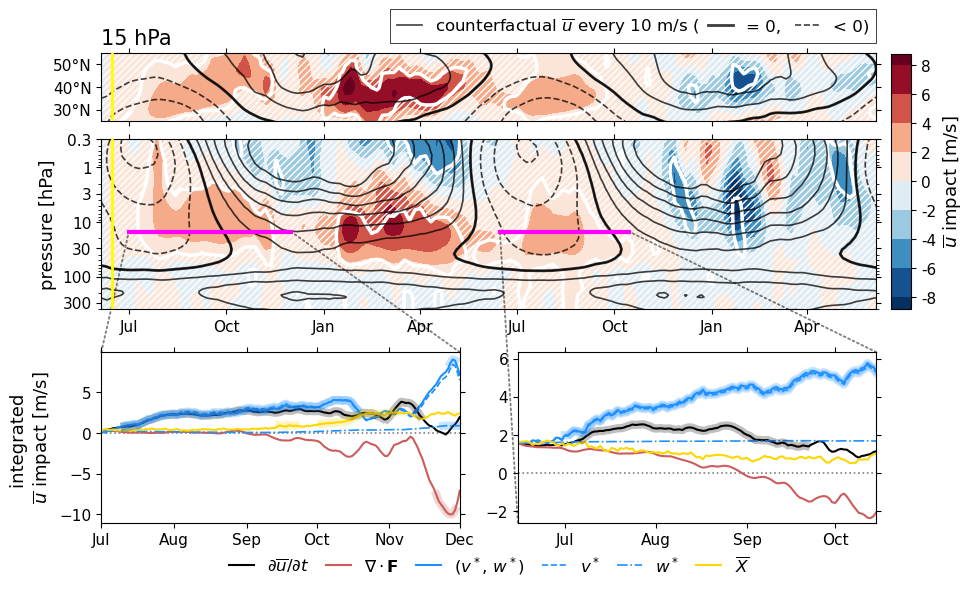

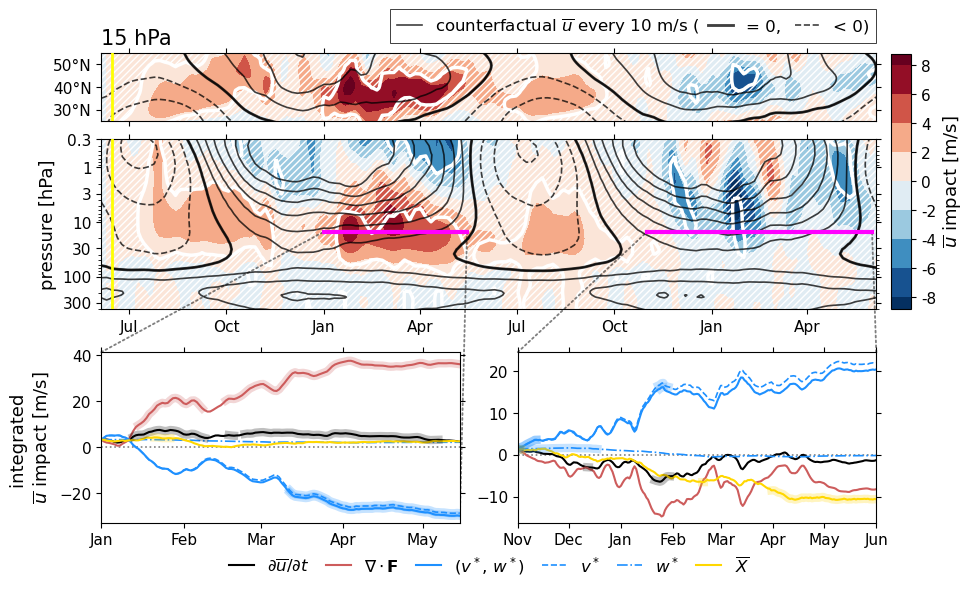

plotting NH tropics...
plotting NH tropics...


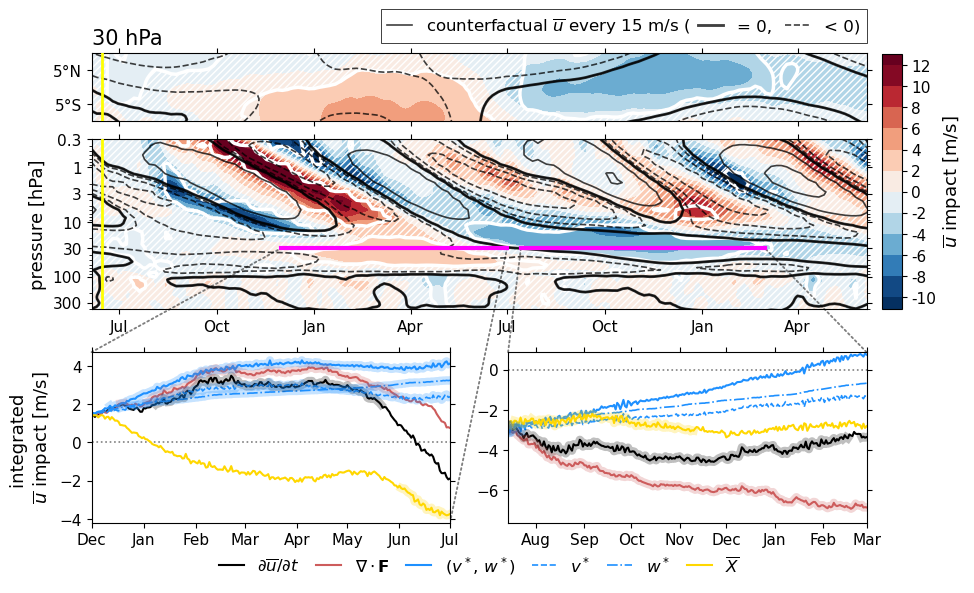

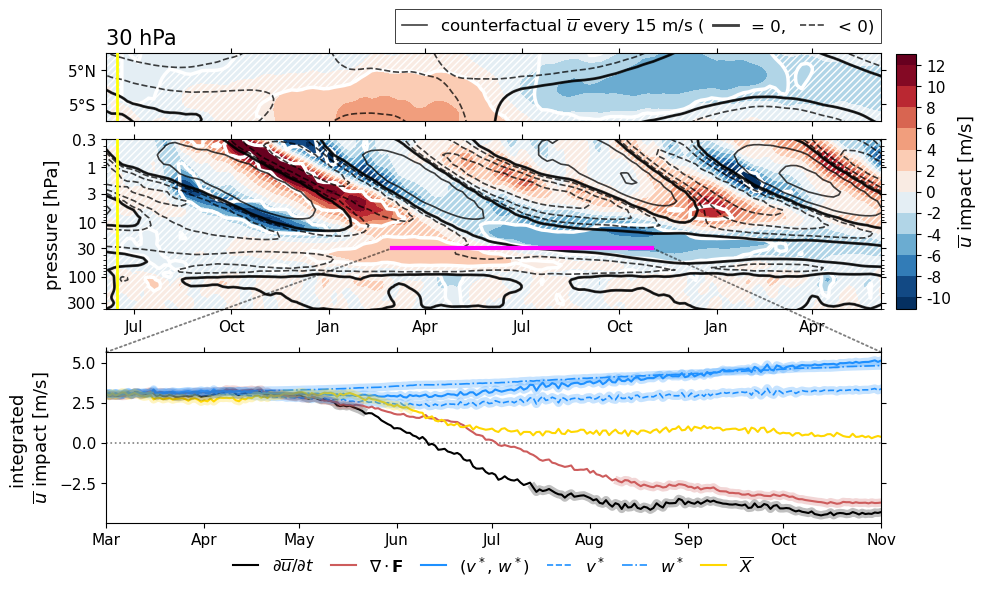

In [9]:
importlib.reload(putil)
importlib.reload(ces)

#sigvar = 'coherence'
sigvar = 'pval'

# ========== NORTHERN MIDLATS

print('plotting NH midlats...')
latband = [30, 50]
plev = 15
ilev = np.arange(-8, 8+1, 2)
ulev = np.arange(-30, 60+1, 10)
budgetlim = [[date(1991, 7, 1), date(1991, 12, 1)], 
             [date(1992, 6, 15), date(1992, 10, 15)]]
make_plot(latband, plev, ulev, ilev, budgetlim, sigvar)

print('plotting NH tropics...')
# ========== TROPICS
latband = [-5, 5]
plev = 30
ilev = np.arange(-10, 12+1, 2)
ulev = np.hstack([np.arange(-45, -15+1, 15), [-5, 0], np.arange(15, 45+1, 15)])
budgetlim = [[], 
             [date(1992, 3, 1), date(1992, 11, 1)]]
make_plot(latband, plev, ulev, ilev, budgetlim, sigvar)

if(0):
    print('plotting NH polar...')
    # ========== NORTHERN POLAR
    latband = [45, 65]
    plev = 1
    ilev = np.arange(-8, 8+1, 2)
    ulev = np.arange(-30, 60+1, 10)
    budgetlim = [[date(1991, 9, 1), date(1992, 7, 1)], 
                 [date(1992, 11, 1), date(1993, 4, 1)]]
    make_plot(latband, plev, ulev, ilev, budgetlim, sigvar)
    
plt.show()